In [21]:
#import library
import json
import requests
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
import datetime as dt
import numpy as np


In [22]:
def getPrice():
  global price_list 
  for tool in tool_list:
    try:
      tool_query = tool.replace(' ', '%20')
      url = "https://wax.api.atomicassets.io/atomicmarket/v1/sales/templates?symbol=WAX&collection_name=alien.worlds&match="+tool_query+"&page=1&limit=1&order=asc&sort=price"
      r = requests.get(url)
      json_data = r.json()
      data = json_data['data'][0]
      price = data['price']
      token_precision = price['token_precision']
      amount = price['amount']
      wax = float(amount)/float(10**token_precision)
      print({tool: wax})
      price_list.append((tool,wax))
    except:
      pass
  return price_list
def updatePrice():
  global tools
  getPrice()
  for item in price_list:
    tool, price = item
    tools.loc[tools.name == tool, 'price'] = price
  tools.to_csv('data/tool.csv', index=False)
def fetchPrice(symbols):
  url = "https://api.binance.com/api/v3/avgPrice?symbol="+symbols
  response = requests.get(url)
  json_data = response.json()
  return float(json_data['price'])
def combineData():
  cwd = os.getcwd()
  minedata = cwd+'/minedata'
  datafile = os.listdir(minedata)
  mine_data = pd.DataFrame({'date': [], 'planet': [], 'max_minerable': []})
  for file in datafile:
    small_data = pd.read_csv('minedata/'+file)
    mine_data = pd.concat([mine_data,small_data], ignore_index=True)
  mine_data['date'] = mine_data['date'].astype('datetime64')
  mine_data['month'] = mine_data['date'].dt.month
  mine_data['day'] = mine_data['date'].dt.day
  mine_data['hour'] = mine_data['date'].dt.hour
  mine_data['minute'] = mine_data['date'].dt.minute
  mine_data['second'] = mine_data['date'].dt.second
  return mine_data

def calc_data_range(data):
  return max(data) - min(data)

def min_criteria(data):
  max_value = max(data)
  data_range = calc_data_range(data)
  return (max_value - data) / data_range

def max_criteria(data):
  min_value = min(data)
  data_range = calc_data_range(data)
  return (data - min_value) / data_range

def evaluate_critera(data, is_min_evalute):
  return min_criteria(data) if is_min_evalute else max_criteria(data)

In [23]:
# mine_data = combineData()
mine_data = pd.read_csv('data.csv')
#Check updated data
print("Updated at: ",mine_data.date.max())
today = dt.datetime.today().day
land = pd.read_csv('data/land.csv')
tools = pd.read_csv('data/tool.csv')
combination = pd.read_csv('data/combination.csv')
second_per_day = 60*60*24
cpu_per_trans = 0.55
wax_per_cpu = 12
price_list = []
# mining_pot = mine_data.groupby('planet').median().mean().max_minerable
mining_pot = 0.7
tool_list = tools.name
my_wax = 3450
tlm = fetchPrice("TLMUSDT")
wax = fetchPrice("WAXPUSDT")
tlm_to_wax = tlm/wax
hours_mining = 14/24

Updated at:  2022-03-09 13:52:43.184480


In [24]:
updatePrice()   
merged_data = combination.merge(land,left_on='land',right_on='name').merge(tools, left_on='tool', right_on='name', suffixes=['_land', '_tool'])
merged_data['price'] = np.round(merged_data['price'],1)
merged_data['price_USDT'] = np.round(merged_data['price'] * wax,1)
merged_data['charge_time'] = merged_data['charge_time_land']*merged_data['charge_time_tool']*2
merged_data['total_mining'] = merged_data['mining_multiplier']*merged_data['mining_power']*3
merged_data['trans'] =  np.round(second_per_day/merged_data['charge_time']*hours_mining)
merged_data['cpu']= np.round(merged_data['trans']*cpu_per_trans)
merged_data['wax_stake_peracc'] = np.round(merged_data['cpu']*wax_per_cpu)
merged_data['wax_total_cost_peracc'] = merged_data['price']*3 + merged_data['wax_stake_peracc']
merged_data['tlm_peracc_daily'] = np.round(merged_data['total_mining']*mining_pot*merged_data['trans']/100,1)
merged_data['wax_peracc_daily']=merged_data['tlm_peracc_daily']*tlm_to_wax
merged_data['accounts'] = np.round(my_wax/merged_data['wax_total_cost_peracc'],1)
merged_data['accounts_score'] = min_criteria(merged_data.accounts)
merged_data['wax_gross_daily'] = merged_data['wax_peracc_daily']*merged_data['accounts']
merged_data['wax_gross_monthly'] = merged_data['wax_gross_daily']*30
merged_data['wax_fixed_cost_monthly'] = merged_data['accounts']*5 + merged_data['wax_gross_daily'] + merged_data.wax_gross_daily*3
merged_data['wax_net_monthly'] = np.round(merged_data['wax_gross_monthly'] - merged_data['wax_fixed_cost_monthly'])
merged_data['USD_net_monthly'] = np.round(merged_data['wax_net_monthly']*wax)
merged_data['ROI_tool_each_acc'] = np.round(merged_data['price']*3/merged_data['wax_peracc_daily'])
merged_data['percent_interest_monthly'] = np.round(merged_data['wax_net_monthly']/my_wax*100,1)
merged_data['ROI_tool_score'] = min_criteria(merged_data['ROI_tool_each_acc'].values)
merged_data['interval_new_acc'] = np.round(merged_data.wax_total_cost_peracc / merged_data.wax_net_monthly * 30)
merged_data['interval_score'] = min_criteria(merged_data['interval_new_acc'])
merged_data['interest_score'] = max_criteria(merged_data['percent_interest_monthly'].values)
merged_data['score'] = merged_data.ROI_tool_score * 0.3 + merged_data.interest_score * 0.3 + merged_data.interval_score * 0.4
merged_data.sort_values('score', ascending=False).to_csv('full_results.csv')

short_result = merged_data.loc[:,~merged_data.columns.isin(['name_land', 'name_tool',
                                                          'mining_power', 'charge_time_tool',\
                                                          'total_mining','trans',
                                                          'tlmPerSec', 'ROI_tool_score',
                                                          'interest_score', 'wax_fixed_cost_monthly', 
                                                          'interval_score', 'mining_multiplier', 
                                                          'price_USD', 'wax_peracc_daily',
                                                          'accounts_score','wax_gross_daily',
                                                          'wax_gross_monthly'])]
short_result.sort_values('score', ascending=False).to_csv('short_result.csv', index=False)

short_result.sort_values('score', ascending=False).head(10)


{'Infused Extractor': 257.0}
{'Basic Explosive': 265.0}
{'Large Capacitor': 310.0}
{'Advanced TD': 360.0}
{'Artunian Shovel': 334.9999}
{'Gasrigged Extractor': 210.0}
{'Power Extractor': 171.97986577}
{'Power Saw': 215.0}
{'Basic Trilium Detector': 149.9}
{'Bananominer': 197.535}
{'Nanominer': 197.535}
{'Standard Drill': 50.9}
{'ExoGloves': 18.0}


,land,tool,charge_time_land,price,price_USDT,charge_time,cpu,wax_stake_peracc,wax_total_cost_peracc,tlm_peracc_daily,accounts,wax_net_monthly,USD_net_monthly,ROI_tool_each_acc,percent_interest_monthly,interval_new_acc,score
141,Icy Mountains,Basic Trilium Detector,2.0,149.9,18.0,680.0,41.0,492.0,941.7,11.8,3.7,285.0,34.0,143.0,8.3,99.0,0.957837
142,Icy Desert,Basic Trilium Detector,1.7,149.9,18.0,578.0,48.0,576.0,1025.7,12.4,3.4,276.0,33.0,136.0,8.0,111.0,0.945881
145,Geothermal Springs,Basic Trilium Detector,1.5,149.9,18.0,510.0,54.0,648.0,1097.7,13.3,3.1,271.0,33.0,127.0,7.9,122.0,0.943194
136,Dormant Volcano,Basic Trilium Detector,2.5,149.9,18.0,850.0,32.0,384.0,833.7,10.4,4.1,276.0,33.0,162.0,8.0,91.0,0.940092
139,Rocky Coastline,Basic Trilium Detector,2.0,149.9,18.0,680.0,41.0,492.0,941.7,11.2,3.7,269.0,32.0,150.0,7.8,105.0,0.933719
135,Mountains,Basic Trilium Detector,3.0,149.9,18.0,1020.0,27.0,324.0,773.7,9.1,4.5,262.0,31.0,185.0,7.6,89.0,0.916269
231,Dormant Volcano,Standard Drill,2.5,50.9,6.1,600.0,46.0,552.0,704.7,7.4,4.9,227.0,27.0,77.0,6.6,93.0,0.905317
183,Geothermal Springs,Infused Extractor,1.5,257.0,30.9,1080.0,26.0,312.0,1083.0,12.6,3.2,264.0,32.0,229.0,7.7,123.0,0.904014
230,Mountains,Standard Drill,3.0,50.9,6.1,720.0,38.0,456.0,608.7,6.5,5.7,229.0,27.0,88.0,6.6,80.0,0.903319
221,Geothermal Springs,Power Extractor,1.5,172.0,20.7,810.0,34.0,408.0,924.0,10.4,3.7,249.0,30.0,186.0,7.2,111.0,0.896640


(0.0, 4.0)

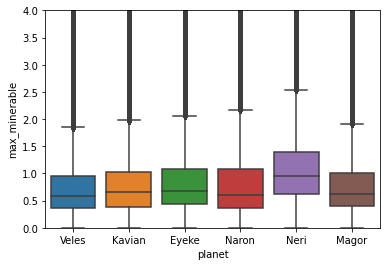

In [25]:
                  
sns.boxplot(data=mine_data, x='planet', y='max_minerable')
plt.ylim(0,4)


([<matplotlib.axis.XTick at 0x7f77a7a3e190>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

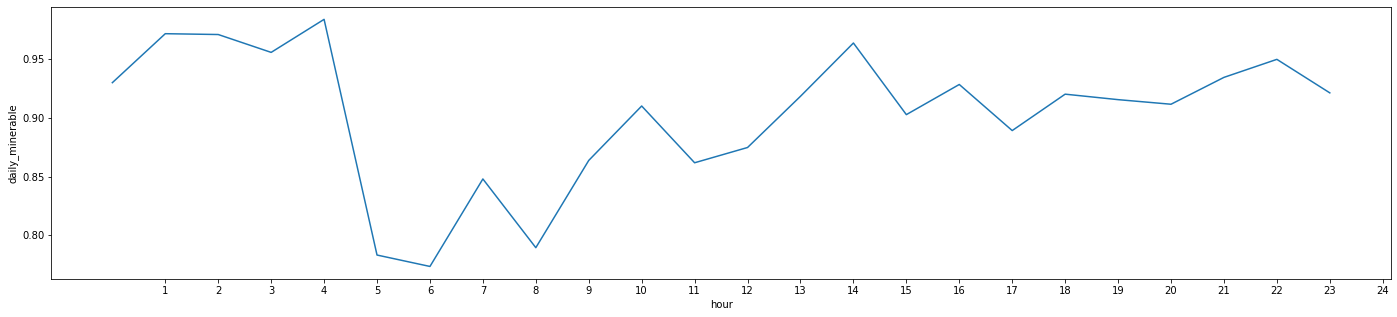

In [26]:
planets = ['Eyeke', 'Kavian', 'Magor', 'Naron', 'Neri', 'Veles']
mine_data = mine_data[mine_data.planet.isin(planets)]
hour = mine_data.sort_values('hour').hour.drop_duplicates().reset_index().hour
daily_minerable = mine_data.groupby('hour').max_minerable.mean().reset_index().max_minerable
daily_mine = pd.DataFrame({'hour': hour, 'daily_minerable': daily_minerable})
fig, ax = plt.subplots(figsize=(24,5))
sns.lineplot(data=daily_mine,x='hour',y='daily_minerable')
# plt.yscale('log')
plt.xticks(range(1,25,1))
# daily_minerable = mine_data.groupby('day')['max_minerable'].mean()

Text(0.5, 1.0, 'Average mining pot')

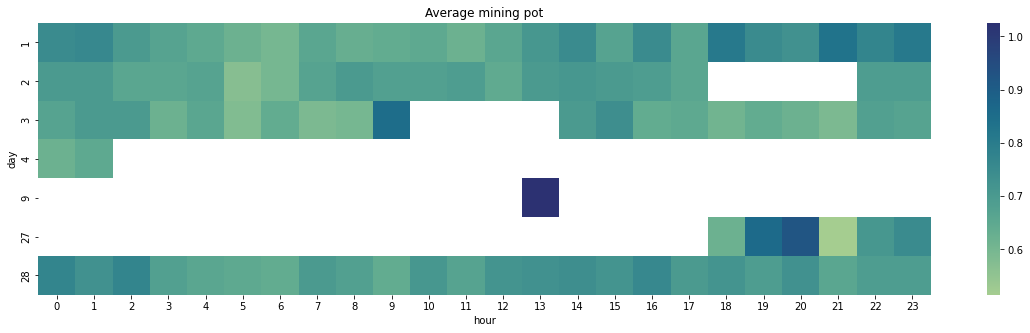

In [27]:
df_crosstab = pd.crosstab(mine_data['day'],mine_data['hour'],values=mine_data['max_minerable'], aggfunc="median")
fig, ax = plt.subplots(1,1, figsize = (20,5))
sns.heatmap(df_crosstab, cmap='crest')
plt.title("Average mining pot")